# Example - Search for the minima of a LJ-8 cluster
Here we search for the global minimum for a particular LJ cluster using AIRSS.
Steps:
1. Define the seed in a `ase.Atoms` like interactive way
2. Call the `buildcell` program to build random structures
3. Optimize the structure using ase's implementation of LJ potential (e.g `LennardJones` calculator) and *BFGS* minimizer
4. Go to step 2, repeat until we are satisfied
5. Analyse the results: minimum energy, density of structures e.t.c.

In [68]:
%matplotlib inline

In [5]:
import os
from airsspy import SeedAtoms, Buildcell
import pandas as pd
from ase.visualize import view
from ipypb import ipb as tqdm

In [67]:
# Create the seed
ljatoms = SeedAtoms('H', cell=(20, 20, 20, 90, 90, 90))

# Configure tags for generation
ljatoms[0].num = 8
ljatoms.gentags.posamp = 4
ljatoms.gentags.fix = True
ljatoms.gentags.nform = 1
ljatoms.gentags.cluster = True
# Request a minsep of 0.5
ljatoms.gentags.minsep = 0.5
# Request 2-4 symmetry opterations 
ljatoms.gentags.symmops = (2, 4)
ljatoms.gentags.slack = 0.1
# Use a sphere confining potential
ljatoms.gentags.sphere = 3


In [43]:
# Create a Buildcell instance
bc = Buildcell(ljatoms)

In [44]:
# Preview the settings to be sent to `buildcell`
print('\n'.join(ljatoms.get_cell_inp_lines()))

%BLOCK lattice_cart
20.0000000000  0.0000000000  0.0000000000
0.0000000000  20.0000000000  0.0000000000
0.0000000000  0.0000000000  20.0000000000
#FIX
%ENDBLOCK lattice_cart
%BLOCK positions_abs
H  0.0000000000 0.0000000000 0.0000000000 # H0 % NUM=8
%ENDBLOCK positions_abs
#POSAMP=4
#NFORM=1
#CLUSTER
#MINSEP=0.5
#SYMMOPS=2-4
#SLACK=0.1
#SPHERE=3



We can already start to build the random atoms

In [45]:
atoms = bc.generate(timeout=1)

Raw stdin and stdout are captured by the wrapper instnace

In [46]:
print('#' * 10 + 'INPUTS' + '#' * 10 + '\n')
print(bc.bc_in)
print('#' * 10 + 'STDERR-DEBUG' + '#' * 10 + '\n')
print(bc.bc_err)
print('#' * 10 + 'STDOUT-Random structure' + '#' * 10 + '\n')
print(bc.bc_out)


##########INPUTS##########

%BLOCK lattice_cart
20.0000000000  0.0000000000  0.0000000000
0.0000000000  20.0000000000  0.0000000000
0.0000000000  0.0000000000  20.0000000000
#FIX
%ENDBLOCK lattice_cart
%BLOCK positions_abs
H  0.0000000000 0.0000000000 0.0000000000 # H0 % NUM=8
%ENDBLOCK positions_abs
#POSAMP=4
#NFORM=1
#CLUSTER
#MINSEP=0.5
#SYMMOPS=2-4
#SLACK=0.1
#SPHERE=3

##########STDERR-DEBUG##########

Using a confining sphere of radius  3.00
Symm: Cn         Nops:   3
Formula units:    1
Cell not compacted
Mult:      3  3  1  1
Applying slack of: 0.100
--~
Timed:        0.00000
Total:        0.01562
Perc:         0.0%

##########STDOUT-Random structure##########

#              Generated by Buildcell
#
# at 12:25:27 (GMT+1.0) 23rd May 2019
# in /home/bonan/appdir/airss-ase/examples
# on DESKTOP-EMLNJAS
# by bonan
#
# compiler GCC version 7.3.0
# options -cpp -imultiarch x86_64-linux-gnu -mtune=generic -march=x86-64 -g -O0
#
# seed  1186664376 -1126960460  -356459615   419719427  

The ase's modules can be used to optimized the random structure generated

In [69]:
# Optimization can be done with Python using ASE
from ase.calculators.lj import LennardJones
from ase.optimize import FIRE
from ipypb import track  # <-- This gives a nice progress bar

# Create the calcluator
lj = LennardJones(epsilon=1, sigma=1, rc=3)

In [70]:
def airss_search(seed, alist, calc, opti_class, max_search=100):
    """
    Conduct a simple AIRSS search. Randomly genrate candiates and relax
    them.
    """
    min_eng = 9999
    for i in tqdm(range(max_search), total=max_search):
        # Requires `buildcell` in PATH
        atoms, bc = seed.build_random_atoms(also_buildcell=True)
        alist.append(atoms)
        atoms.set_calculator(calc)
        opti = opti_class(atoms=atoms, logfile=None)
        opti.run(fmax=0.05)
        atoms.cached_energy = atoms.get_potential_energy()
        if atoms.cached_energy < min_eng:
            min_eng = atoms.cached_energy
            print(min_eng)

Run the search generate 100 clusters and relax them

In [71]:
results = []
airss_search(ljatoms, results, lj, FIRE, 100)

 [████████████████████████████████████████████████████████████] 100/100 [00:17<00:00, 0.17s/it]

-11.941537391969977
-19.668017795755578


## Analyse the results

In [72]:
def process(atoms):
    """Collect results"""
    sep_all = atoms.get_all_distances(mic=True)
    sep_all[sep_all > 0].min()
    res = {
        'formula': atoms.get_chemical_formula(),
        'natoms': len(atoms),
        'minsep': sep_all[sep_all > 0].min(),
        'volume': atoms.get_volume(),
        'energy': atoms.cached_energy
    }
    return res

Minimum energy found: -19.66802


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77dd97f630>]],
      dtype=object)

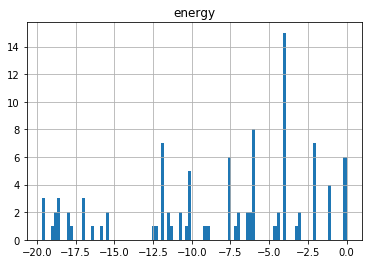

In [73]:
# Collect the data into a dataframe and analyse
df = pd.DataFrame([process(atoms) for atoms in results[:500]])

idmin = df.energy.idxmin()
mineng = df.energy.loc[idmin]
print('Minimum energy found: {:.5f}'.format(mineng))
df.hist('energy', bins=100)

Find which structure have lower energies

In [74]:
## Get the 'clusters' in energy
tmp = df.sort_values('energy')
groups = []
current_group = 0
current_index = []
last_eng = -9999
for idx, row in tmp.iterrows():
    if abs(last_eng - row.energy) > 0.01 and current_index:
        current_group += 1
        groups.append([last_eng, current_index])
        current_index = []
    else:
        current_index.append(idx)
    last_eng = row.energy

for eng, index in groups:
    print('Energy: {:.3f} - indices {}'.format(eng, ', '.join(map(str, index))))

Energy: -19.668 - indices 3, 71, 48
Energy: -18.823 - indices 50, 42
Energy: -18.625 - indices 74, 44
Energy: -17.955 - indices 13
Energy: -16.945 - indices 75, 86, 72
Energy: -15.870 - indices 5
Energy: -15.478 - indices 30
Energy: -12.221 - indices 31
Energy: -11.934 - indices 0, 41, 68, 16, 39, 23
Energy: -11.522 - indices 32
Energy: -10.710 - indices 1, 35
Energy: -10.082 - indices 52, 20, 18, 29, 24
Energy: -8.895 - indices 34
Energy: -7.475 - indices 46, 11, 80, 7, 61
Energy: -6.977 - indices 99
Energy: -6.437 - indices 17, 78
Energy: -6.257 - indices 43
Energy: -6.075 - indices 47
Energy: -5.967 - indices 59, 26, 49, 38, 73
Energy: -4.448 - indices 88, 89
Energy: -4.033 - indices 2
Energy: -3.978 - indices 97, 45, 37, 4, 81, 64, 69, 58, 92, 60, 56, 8
Energy: -2.984 - indices 19, 93
Energy: -1.989 - indices 15, 84, 6, 14, 27, 33
Energy: -1.011 - indices 57, 28
Energy: -0.024 - indices 21, 51, 87


## Known minima configuration
From http://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html

In [75]:
c8_pos = """
          0.2730989500        1.1469629952       -0.3319578813
         -0.4728837298       -0.6223685080        0.7664213265
         -0.9666537615       -0.2393056630       -0.1698094248
          0.6209419539       -0.3628130566        0.7094425990
          0.8035441992        0.1648033307       -0.2639206823
         -0.1784380914        0.2412141513       -0.8077599510
          0.0639788373       -0.6647479592       -0.2089132333
         -0.1435883576        0.3362547097        0.3064972473
"""
c8_pos = c8_pos.split('\n')
c8_pos = [list(map(float, l.strip().split())) for l in c8_pos if l]
c8 = SeedAtoms('H8', positions=c8_pos)

Energy of the global minimum - have we find the global minmum?

In [76]:
lj.get_potential_energy(c8)

-19.668064818966037